# Implementación de un pasabanda mediante el conversor generalizado de impedancias

<img src="./img/logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 

En este notebook se analizará la respuesta en frecuencia de un **filtro pasabanda activo** implementado mediante el conversor generalizado de impedancias de [Andreas Antoniou](https://ieeexplore.ieee.org/author/37276841000) en 1969 [1]. Se aprovecha el ejemplo para demostrar el uso de las siguientes funciones de PyTC2:

* [bodePlot](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.bodePlot)
* [print_latex](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/general/index.html#pytc2.general.print_latex)
* [a_equal_b_latex_s](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/general/index.html#pytc2.general.a_equal_b_latex_s)
* [symbfunc2tf]()
* [factorSOS]()

[1] A. Anotniou. [*Realisation of gyrators using operational amplifiers, and their use in RC-active-network synthesis*](https://drive.google.com/file/d/1joumLPy2mgb4ejy2ld_ywwJKN_i40eeL/view?usp=drive_link). PROC. IEE, Vol. 116, No. II, NOVEMBER 1969.


### Introducción

En este documento se analizará el conversor generalizado de inmitancias (impedancias o admitancias) propuesto por Antoniou  (GIC de aquí en adelante). Este circuito es especialmente útil para implementar funciones de excitación en su puerto de entrada que dependen de las 5 admitancias que componen la red. Algunos ejemplos que se estudiarán son giradores, resistores negativos dependientes de la frecuencia (FDNR), entre otras posibilidades que se pueden implementar con esta red. El circuito que representa al GIC de Antoniou es muy llamativo:

<img src="./img/GIC_Antoniou.png" alt="GIC Antoniou" width="700px" style="border:10px solid white; display: block; margin: 0 auto;">

Se procede ahora al análisis de la red para hallar concretamente la admitancia en el puerto 1, $Y_1 = \frac{I_1}{V_1}$


Planteamos las ecuaciones de nodos, quedando en forma matricial de la siguiente forma

$$ v.Y-i = 0$$

que se procederá a resolver con el solver de ecuaciones lineales de SymPy

In [1]:
import sympy as sp
from pytc2.remociones import remover_polo_dc
from pytc2.general import a_equal_b_latex_s, print_latex, s, symbfunc2tf, factorSOS
from pytc2.sistemas_lineales import bodePlot

# tensiones y corrientes que usaremos para nuestros análisis
I1, V1, V2, V3, V4, V5 = sp.symbols("I1, V1, V2, V3, V4, V5")
Y1, Y2, Y3, Y4, Y5, As = sp.symbols("Y1, Y2, Y3, Y4, Y5, As")
G, C, wt, w0 = sp.symbols("G, C, wt, w0", real = True, posistive = True) 



Se aprovecharán las capacidades simbólicas para mostrar lo sencillo que puede ser analizar un circuito como el GIC, con diferentes complejidades algebraicas. Para ello planteamos tres análisis en orden de complejidad creciente:

1. Amplificadores operacionales (OpAmp) ideales, realimentados negativamente
2. OpAmp's ideales, sin considerar realimentación negativa.
3. OpAmp's basados en el modelo de un solo polo en el origen o integrador.

### OpAmp's ideales, realimentados negativamente

El caso más sencillo se modela con la siguiente ecuación matricial, que arroja el resultado más conocido del GIC.
  

In [2]:
# modelo ideal negativamente realimentado
aa = sp.solve([ 
                V1*Y1 - V2*Y1 - I1, 
                -V2*Y2 + V1*(Y2+Y3) -V3*Y3,
                -V3*Y4 + V1*(Y4+Y5)
                ], 
                [V1, V2, V3])
Z1 = aa[V1]/I1

print_latex(a_equal_b_latex_s('Z_1 = \\frac{V_1}{I_1}', Z1))


<IPython.core.display.Math object>

### Sin asumir realimentación negativa

Un paso de complejidad siguiente podría ser considerar que los OpAmp's no están realimentados negativamente, y en consecuencia la tensión en su pata inversora y no inversora no son iguales. Luego se debería imponer que la ganancia de cada OpAmp tiende a infinito, y analizar la impedancia $Z_1$. Para ello se plantea:


In [3]:
aa = sp.solve([ 
                V1*Y1 - V2*Y1 - I1, 
                -V2*Y2 + V3*(Y2+Y3) -V4*Y3,
                -V4*Y4 + V5*(Y4+Y5),
                As*(V5-V3) - V2, 
                As*(V1-V3) - V4, 
                ], 
                [V1, V2, V3, V4, V5])

Z12 = aa[V1]/I1

print_latex(a_equal_b_latex_s('Z_{12}', Z12))


<IPython.core.display.Math object>

Como se observa la expresión se complica enormemente, a menos que consideremos $A_s \to \infty$

In [4]:
# modelo ideal sin asumir realimentación negativa
Z122 = sp.limit(Z12, As, sp.oo)

print_latex(a_equal_b_latex_s('Z_{12} = Z_1', Z122))


<IPython.core.display.Math object>

Esto quiere decir que la asunción de realimentación negativa es correcta.

A partir de ahora se considerará un modelo de OpAmp más complicado, que permitirá acercarse un poco más a una simulación más realista.

### Análisis con OpAmp como integrador

Desde el punto conceptual y algebraico, basta con asumir 

$$ A_s = \frac{\omega_t}{s}$$

esto trae aparejado expresiones un tanto más complejas, que deben analizarse con más cuidado. Recordar que $\omega_t$ puede interpretarse como la pulsación a la cual un opamp tiene una ganancia unitaria o de 0 dB. También se lo puede asemejar al **producto ganancia-ancho de banda** (GBP).

Por este motivo, primero se revisará para el caso más sencillo cómo es el comportamiento del GIC en su configuración como *girador* de impedancias. 

$$ Z_1 = \frac{r^2}{Z_2}$$

Donde el comportamiento del girador anticipa que una $Z_2$ conectada en un puerto, será *girada* en su naturaleza reactiva cuando se la observe desde el otro puerto, como $Z_1$. La constante $r$ sirve como factor de proporcionalidad entre ambas impedancias y se mide en ohms. Esto quiere decir que una reactancia capacitiva en $Z_2$ se verá como **inductiva** en $Z_1$. En nuestro GIC, haciendo $Y_2 = s.C$ y todas las demás $Y_x = 1/R$ (x:1,3-5) resulta en

$$ Z_1 = s. L_{eq} = s.R^2.C$$

con $L_{eq} = R^2.C$. 

Ahora si se procede a aumentar la complejidad algebraica al considerar $ A_s = \frac{\omega_t}{s}$

In [5]:
Z13 = sp.simplify(sp.expand(Z12.subs(As, wt/s)))

print_latex(a_equal_b_latex_s('Z_{13}', Z13))


<IPython.core.display.Math object>

Ahora se procede a configurar al GIC como girador, para obtener

In [6]:
Z13 = sp.simplify(sp.expand(Z13.subs({Y1:G, Y2:s*C, Y3:G, Y4:G, Y5:G})))

print_latex(a_equal_b_latex_s('Z_{1}', Z13))


<IPython.core.display.Math object>

Si bien la expresión se simplifica notablemente, aún conserva bastante complejidad, sobretodo si se recuerda que el comportamiento debería ser similar a un inductor de valor $L_{eq}$, como el que fue hallado más arriba.

A partir de ahora se sugiere pasar a un análisis numérico para ganar algo de perspectiva respecto a la respuesta en frecuencia de $Z_1$. Para ello asignaremos valores *razonables* a las variables $\omega_t$, $C$ y $G$.


In [7]:
Z1num = sp.simplify(sp.expand(Z13.subs({wt:100, G:1, C:1})))

print_latex(a_equal_b_latex_s('Z_{1}', Z1num))


<IPython.core.display.Math object>

Asumimos una $\omega_t=100$, lo que implicaría que el GBP del OpAmp está 100 veces por encima de la frecuencia de operación del GIC. Este valor persigue una finalidad didáctica antes que realista, dado que se pretende mantener coeficientes no demasiado grandes. En la práctica este valor podría ser bastante más elevado. Factorizando la expresión se obtiene

In [8]:
Z1num, _, _ = factorSOS(Z1num)

print_latex(a_equal_b_latex_s('Z_{1}', Z1num))


<IPython.core.display.Math object>

Y de esta manera se comienza a tomar algo de perspectiva del comportamiento realista del GIC. El comportamiento inductivo se afectará por la/s singularidades de menor frecuencia. En este caso, siguiendo el orden: 1) los polos complejos conjugados de radio $\sqrt{49.8} \approx 7$, luego 2) los ceros de $\sqrt{5100} \approx 71$ y finalmente 3) el polo en 101.

En el siguiente análisis se observa cómo a dichas frecuencias se obtienen puntos de inflexión en las curvas de respuesta.

Primero inicializamos el entorno gráfico

In [9]:
# Inicialización e importación de módulos

# Módulos externos
import matplotlib as mpl
import matplotlib.pyplot as plt

# Esta parte de código la agregamos SOLO en los notebooks para fijar el estilo de los gráficos.
fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi
fig_font_size = 11

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})

ahora si continuamos con la respuesta en frecuencia

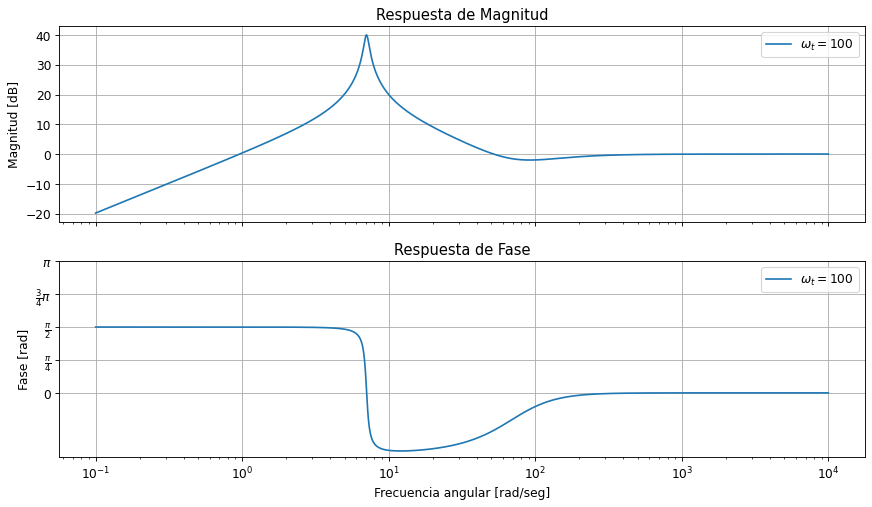

In [10]:
fig_id, axes_hdl = bodePlot(symbfunc2tf(Z1num), filter_description='$\omega_t = {:d}$'.format(100), fig_id=1)

En el siguiente análsis, se observa la dependencia del GIC respecto al GBP del OpAmp y en comparativa se incorpora el comportamiento del girador idealizado.

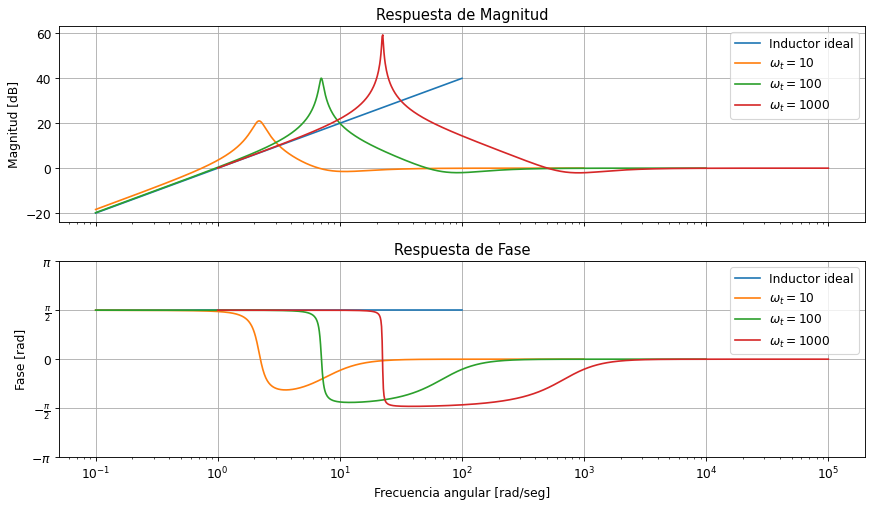

In [11]:
Z1_ideal = sp.simplify(sp.expand(Z1.subs({Y1:G, Y2:s*C, Y3:G, Y4:G, Y5:G})))
Z1_ideal = Z1_ideal.subs({G:1, C:1})

wt_all = [10, 100, 1000]
fig_id, axes_hdl = bodePlot(symbfunc2tf(Z1_ideal), filter_description='Inductor ideal')

for wti in wt_all:

    fig_id, axes_hdl = bodePlot(symbfunc2tf(sp.simplify(sp.expand(Z13.subs({wt:wti, G:1, C:1})))), filter_description='$\omega_t = {:d}$'.format(wti), fig_id=1)


Notar cómo el alejamiento de las tres curvas respecto del comportamiento idealizado indica el ancho de banda útil del GIC de Antoniou. Para el caso analizado de $\omega_t=100$, esto ocurre algo antes de los 7 r/s (curva verde).  Ciertamente a mayor GBP, mayor ancho de banda en el que el girador se comportará como tal.

### Un modelo circuital de $Z_1$

Ahora se intentará obtener una red que responda al comportamiento de $Z_1$, esto es realizar la síntesis de la impedancia de entrada. Para la mayoría de estudiantes que revisa este documento al mismo tiempo que está cursando la asignatura, es posible que no siga al detalle el siguiente procedimiento todavía. Es que se trata de hallar una red a partir de una respuesta en frecuencia, o una función matemática que define una función de excitación. Este tema se verá durante el segundo cuatrimestre, y se puede saltear el siguiente procedimiento.

In [12]:
print_latex(a_equal_b_latex_s('Z_{1}', Z1num))

<IPython.core.display.Math object>

In [13]:
Z1 = sp.simplify(sp.expand(Z13.subs({wt:100, G:1, C:1})))

Y2, YLeq = remover_polo_dc(1/Z1)

Leq = 1/YLeq/s

# parte imaginaria de la variable compleja s
ww = sp.symbols("\omega", real = True)

re_Y2 = sp.simplify(sp.expand(sp.re(Y2.subs({s:(sp.I*ww)}))))

G1 = sp.minimum(re_Y2, ww, domain=sp.Reals)

R1 = 1/G1

Y4 = sp.simplify(sp.expand(Y2 - G1))

Z4 = 1/Y4

Z6, ZC1 = remover_polo_dc(Z4)

C1 = 1/ZC1/s

re_Z6 = sp.simplify(sp.expand(sp.re(Z6.subs({s:(sp.I*ww)}))))

R2 = sp.minimum(re_Z6, ww, domain=sp.Reals)

Z8 = sp.simplify(sp.expand(Z6 - R2))

Y8 = 1/Z8

Y8 =  sp.expand(Y8).as_ordered_terms()

R3 = Y8[0]
L2 = 1/Y8[1]/s


Una vez obtenido los elementos circuitales, podemos agruparlos en un circuito gracias a las posibilidades del módulo [schemdraw](https://schemdraw.readthedocs.io/en/stable/) y [PyTC2](https://pytc2.readthedocs.io/en/stable/).

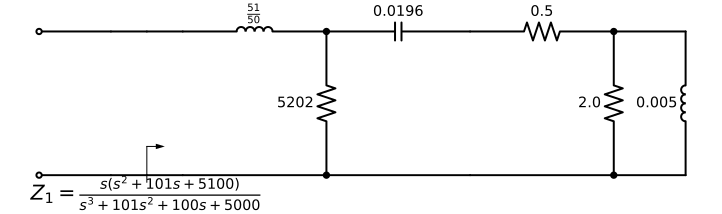

In [14]:
from schemdraw import Drawing
from pytc2.dibujar import dibujar_puerto_entrada, dibujar_funcion_exc_abajo, dibujar_elemento_serie, dibujar_elemento_derivacion, dibujar_espaciador

d = Drawing(unit=4)
d = dibujar_puerto_entrada(d)
d = dibujar_funcion_exc_abajo(d, 
                              'Z_1',  
                              Z1, 
                              hacia_salida = True)

d = dibujar_elemento_serie(d, "L", sym_label=Leq)
d = dibujar_elemento_derivacion(d, "R", sym_label=R1)
d = dibujar_elemento_serie(d, "C", sym_label=C1.evalf(3))
d = dibujar_elemento_serie(d, "R", sym_label=R2.evalf(3))
d = dibujar_elemento_derivacion(d, "R", sym_label=R3.evalf(3))
d = dibujar_espaciador(d)
d = dibujar_elemento_derivacion(d, "L", sym_label=L2.evalf(3), with_nodes=False)
display(d)


Notar cómo el comportamiento inductivo se destaca en bajas frecuencias aproximándose al comportamiento del girador ideal con valor $L_{eq} = 1$.

### Finalmente, la simulación circuital

Una vez que se tiene una buena perspectiva respecto al comportamiento idealizado del GIC, incluso al haber analizado el efecto del GBP en este circuito, se puede continuar con la simulación circuital. Especialmente con el objetivo de utilizar modelos reales de OpAmp's provistos por los fabricantes. Para tal fin se utilizará un resonador pasivo RLC sintonizado a $\omega_0 = 1$ r/s y $Q = 1$, con la finalidad de *activar* el inductor mediante un GIC.

<img src="./img/GIC_resonador.png" alt="GIC Antoniou simulacion1" width="900px" style="border:10px solid white; display: block; margin: 0 auto;">


Notar que en la parametrización de la red, el GBW (GBP en este documento) está 4 órdenes de magnitud por encima de la frecuencia de operación del resonador RLC para asegurar el comportamiento adecuado del GIC, a esa frecuencia y otras que fueron analizadas en otros escenarios de simulación. 


<img src="./img/GIC_resonador_respuesta.png" alt="GIC Antoniou simulacion1" width="900px" style="border:10px solid white; display: block; margin: 0 auto;">


El comportamiento es el esperado para el caso ideal, al verificarse que la red responde de manera similar al análisis numérico y simbólico. A continuación se observa la respuesta inductiva del GIC (en azul), superpuesta a la respuesta pasabanda del resonador (en rojo). Se observa la respuesta en frecuencia para $\mathrm{GBW} = f_0 * 10^k$ para $k = 2, 3, 4$, y la respuesta pasabanda que no cambia significativamente.


<img src="./img/GIC_resonador_respuesta_2.png" alt="GIC Antoniou simulacion1" width="900px" style="border:10px solid white; display: block; margin: 0 auto;">
